# Let's Build a Quant Trading Strategy

## Video 1: Build a ML Model in PyTorch

In [1]:
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [2]:
# y_hat = model(x)
# orders = strategy(y_hat)
# execute(orders)

In [3]:
# regression model => BTCUSDT => future log return

In [4]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities

In [5]:
research.set_seed(42)

In [6]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [7]:
# Trading pair symbol
sym = 'BTCUSDT'
# Historical data window in days (e.g., 6 months)            
hist_data_window = 7 * 4 * 6
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [8]:
binance.download_trades(sym, hist_data_window)

In [9]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 340/340 [00:35<00:00,  9.51file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6
…,…,…,…,…
2025-10-03 19:00:00,122505.7,122930.3,122313.0,122609.3
2025-10-03 20:00:00,122609.3,122694.1,121986.3,122402.2
2025-10-03 21:00:00,122402.3,122406.2,121944.7,122245.2


In [10]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 340/340 [00:36<00:00,  9.36file/s]


datetime,price_median
datetime[μs],f64
2024-10-29 00:00:00,69848.5
2024-10-29 01:00:00,69969.0
2024-10-29 02:00:00,71180.1
2024-10-29 03:00:00,71170.5
2024-10-29 04:00:00,71029.3
…,…
2025-10-03 19:00:00,122617.5
2025-10-03 20:00:00,122288.2
2025-10-03 21:00:00,122244.8


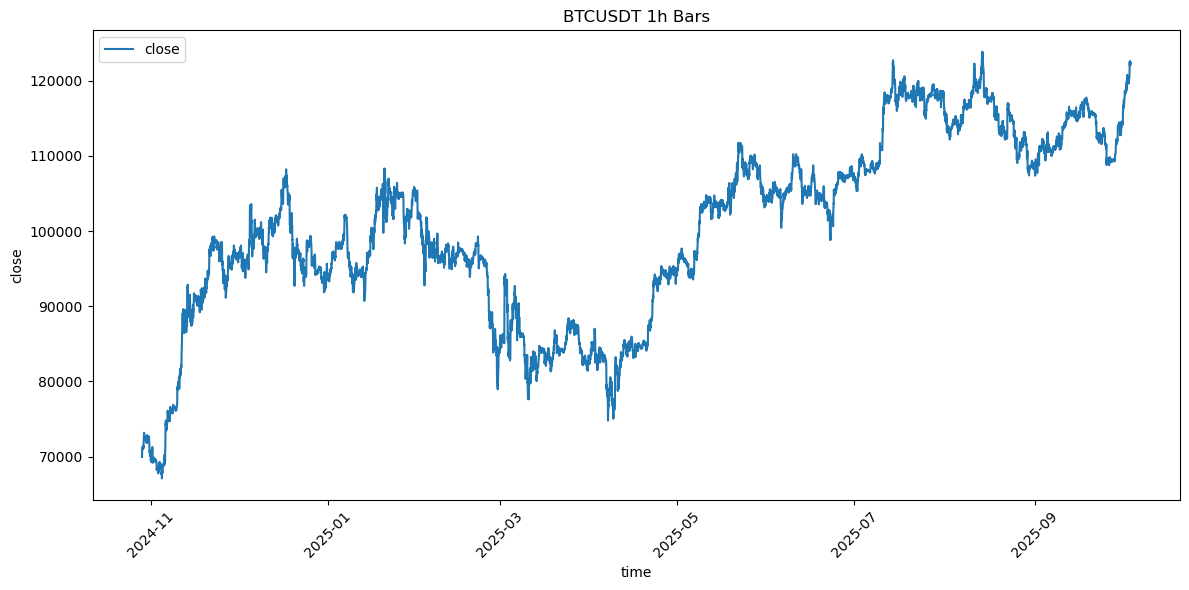

In [11]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [12]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

### Feature Engineering

In [13]:
price_time_series = pl.DataFrame({'price':[100.0,120.0,100.0]})
research.plot_column(price_time_series, 'price')

alt.Chart(...)

In [14]:
price_time_series.with_columns(
    pl.col('price').diff().alias('delta'),
    ((pl.col('price')-pl.col('price').shift())/pl.col('price').shift()).alias('return'),
    (pl.col('price')/pl.col('price').shift()).log().alias('log_return'),
)

price,delta,return,log_return
f64,f64,f64,f64
100.0,null,null,null
120.0,20.0,0.2,0.182322
100.0,-20.0,-0.166667,-0.182322


### Create target and lagged features

In [15]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903
…,…,…,…,…,…
2025-10-03 19:00:00,122505.7,122930.3,122313.0,122609.3,0.000846
2025-10-03 20:00:00,122609.3,122694.1,121986.3,122402.2,-0.001691
2025-10-03 21:00:00,122402.3,122406.2,121944.7,122245.2,-0.001283


In [16]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-03 19:00:00,122505.7,122930.3,122313.0,122609.3,0.000846,0.003845,-0.00402,0.002358,0.01133
2025-10-03 20:00:00,122609.3,122694.1,121986.3,122402.2,-0.001691,0.000846,0.003845,-0.00402,0.002358
2025-10-03 21:00:00,122402.3,122406.2,121944.7,122245.2,-0.001283,-0.001691,0.000846,0.003845,-0.00402


In [17]:
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 00:00:00,69939.9,69998.4,69733.0,69939.5,null,null,null,null,null
2024-10-29 01:00:00,69939.5,70399.4,69810.8,70287.0,0.004956,null,null,null,null
2024-10-29 02:00:00,70286.9,71607.0,70198.1,71173.9,0.012539,0.004956,null,null,null
2024-10-29 03:00:00,71173.8,71409.0,70870.2,70927.5,-0.003468,0.012539,0.004956,null,null
2024-10-29 04:00:00,70927.4,71123.4,70906.1,71062.6,0.001903,-0.003468,0.012539,0.004956,null
…,…,…,…,…,…,…,…,…,…
2025-10-03 19:00:00,122505.7,122930.3,122313.0,122609.3,0.000846,0.003845,-0.00402,0.002358,0.01133
2025-10-03 20:00:00,122609.3,122694.1,121986.3,122402.2,-0.001691,0.000846,0.003845,-0.00402,0.002358
2025-10-03 21:00:00,122402.3,122406.2,121944.7,122245.2,-0.001283,-0.001691,0.000846,0.003845,-0.00402


In [18]:
ts = ts.drop_nulls()

In [19]:
research.plot_distribution(ts, target, no_bins = 100)

alt.Chart(...)

In [20]:
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [21]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [22]:
input_features = 1

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [23]:
# y = w * x + b

### Split by time

In [24]:
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [25]:
len(ts)

8155

In [26]:
int(len(ts) * test_size)

2038

In [27]:
split_idx = int(len(ts) * (1-test_size))
split_idx

6116

In [28]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [29]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-10-29 05:00:00,71062.5,71088.7,70880.3,71010.9,-0.000728,0.001903,-0.003468,0.012539,0.004956
2024-10-29 06:00:00,71010.8,71343.9,70983.1,71226.6,0.003033,-0.000728,0.001903,-0.003468,0.012539
2024-10-29 07:00:00,71226.6,71250.0,70803.0,71004.2,-0.003127,0.003033,-0.000728,0.001903,-0.003468
2024-10-29 08:00:00,71004.1,71208.7,70960.0,71122.1,0.001659,-0.003127,0.003033,-0.000728,0.001903
2024-10-29 09:00:00,71122.1,71332.8,71100.7,71280.0,0.002218,0.001659,-0.003127,0.003033,-0.000728
…,…,…,…,…,…,…,…,…,…
2025-07-10 20:00:00,113246.1,113530.4,113208.4,113426.0,0.001587,-0.001193,-0.00265,0.009598,0.01113
2025-07-10 21:00:00,113426.0,117500.0,113320.7,116459.4,0.026392,0.001587,-0.001193,-0.00265,0.009598
2025-07-10 22:00:00,116459.5,116473.7,115750.0,115983.6,-0.004094,0.026392,0.001587,-0.001193,-0.00265


In [30]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-07-11 01:00:00,115544.9,116039.4,115467.0,115934.7,0.003368,-0.003752,-0.000038,-0.004094,0.026392
2025-07-11 02:00:00,115934.7,116754.3,115670.0,116614.7,0.005848,0.003368,-0.003752,-0.000038,-0.004094
2025-07-11 03:00:00,116614.7,116945.8,116322.0,116839.5,0.001926,0.005848,0.003368,-0.003752,-0.000038
2025-07-11 04:00:00,116839.5,116886.2,116429.2,116858.6,0.000163,0.001926,0.005848,0.003368,-0.003752
2025-07-11 05:00:00,116858.5,118395.9,116858.5,117819.8,0.008192,0.000163,0.001926,0.005848,0.003368
…,…,…,…,…,…,…,…,…,…
2025-10-03 19:00:00,122505.7,122930.3,122313.0,122609.3,0.000846,0.003845,-0.00402,0.002358,0.01133
2025-10-03 20:00:00,122609.3,122694.1,121986.3,122402.2,-0.001691,0.000846,0.003845,-0.00402,0.002358
2025-10-03 21:00:00,122402.3,122406.2,121944.7,122245.2,-0.001283,-0.001691,0.000846,0.003845,-0.00402


In [31]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [32]:
X_train

tensor([[ 1.9030e-03],
        [-7.2779e-04],
        [ 3.0330e-03],
        ...,
        [ 2.6392e-02],
        [-4.0939e-03],
        [-3.7937e-05]])

In [33]:
X_train.shape

torch.Size([6116, 1])

In [34]:
y_train

tensor([-7.2779e-04,  3.0330e-03, -3.1273e-03,  ..., -4.0939e-03,
        -3.7937e-05, -3.7517e-03])

In [35]:
y_train.shape

torch.Size([6116])

In [36]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-7.2779e-04],
        [ 3.0330e-03],
        [-3.1273e-03],
        ...,
        [-4.0939e-03],
        [-3.7937e-05],
        [-3.7517e-03]])

In [37]:
y_train.shape

torch.Size([6116, 1])

In [38]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0034],
        [ 0.0058],
        [ 0.0019],
        ...,
        [-0.0013],
        [ 0.0015],
        [-0.0020]])

In [39]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 1.9030e-03],
         [-7.2779e-04],
         [ 3.0330e-03],
         ...,
         [ 2.6392e-02],
         [-4.0939e-03],
         [-3.7937e-05]]),
 tensor([[-0.0038],
         [ 0.0034],
         [ 0.0058],
         ...,
         [-0.0017],
         [-0.0013],
         [ 0.0015]]),
 tensor([[-7.2779e-04],
         [ 3.0330e-03],
         [-3.1273e-03],
         ...,
         [-4.0939e-03],
         [-3.7937e-05],
         [-3.7517e-03]]),
 tensor([[ 0.0034],
         [ 0.0058],
         [ 0.0019],
         ...,
         [-0.0013],
         [ 0.0015],
         [-0.0020]]))

### Batch Gradient Descent

In [41]:
# hyperparameters
no_epochs = 1000 * 5
lr = 0.0005

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")
    


Training model...
Epoch [500/5000], Loss: 0.001155
Epoch [1000/5000], Loss: 0.000031
Epoch [1500/5000], Loss: 0.000029
Epoch [2000/5000], Loss: 0.000029
Epoch [2500/5000], Loss: 0.000029
Epoch [3000/5000], Loss: 0.000029
Epoch [3500/5000], Loss: 0.000029
Epoch [4000/5000], Loss: 0.000029
Epoch [4500/5000], Loss: 0.000029
Epoch [5000/5000], Loss: 0.000029

Learned parameters
linear.weight:
[[-0.02181353]]
linear.bias:
[8.1233666e-05]

Test Loss: 0.000011, Train Loss: 0.000029


### Test Trading Peformance

In [42]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
0.000163,0.003368,true,1.0,0.003368,0.003368
0.000008,0.005848,true,1.0,0.005848,0.009216
-0.000046,0.001926,false,-1.0,-0.001926,0.00729
0.000039,0.000163,true,1.0,0.000163,0.007454
0.000078,0.008192,true,1.0,0.008192,0.015645
…,…,…,…,…,…
-0.000003,0.000846,false,-1.0,-0.000846,0.003518
0.000063,-0.001691,false,1.0,-0.001691,0.001828
0.000118,-0.001283,false,1.0,-0.001283,0.000544


In [43]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [44]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
0.000163,0.003368,true,1.0,0.003368,0.003368,0.0
0.000008,0.005848,true,1.0,0.005848,0.009216,0.0
-0.000046,0.001926,false,-1.0,-0.001926,0.00729,-0.001926
0.000039,0.000163,true,1.0,0.000163,0.007454,-0.001762
0.000078,0.008192,true,1.0,0.008192,0.015645,0.0
…,…,…,…,…,…,…
-0.000003,0.000846,false,-1.0,-0.000846,0.003518,-0.066597
0.000063,-0.001691,false,1.0,-0.001691,0.001828,-0.068288
0.000118,-0.001283,false,1.0,-0.001283,0.000544,-0.069571


In [45]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.12197740375995636

In [46]:
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.11483163024638832)

In [47]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-114.83163024638831)

In [48]:
win_rate = trade_results['is_won'].mean()
win_rate

0.5012260912211869

In [49]:
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

1.615099208041905e-08

In [50]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

3.2910145819187164e-05

In [51]:
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.000032910687364)

In [52]:
1000*compound_return

np.float64(1000.032910687364)

In [53]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.051861900836229324

In [54]:
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.07011550664901733

In [55]:
std = trade_results['trade_log_return'].std()
std

0.003253547940403223

In [56]:
sharpe = ev / std * annualized_rate
sharpe

np.float64(0.00046461587735830215)

In [58]:
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2039,
 'win_rate': 0.5012260912211869,
 'avg_win': 0.002216762309661036,
 'avg_loss': -0.0022276284647008136,
 'best_trade': 0.02901790291070938,
 'worst_trade': -0.02237566001713276,
 'ev': 1.615099208041905e-08,
 'std': 0.003253547940403223,
 'total_log_return': 3.2910145819187164e-05,
 'compound_return': np.float64(1.000032910687364),
 'max_drawdown': -0.12197740375995636,
 'equity_trough': -0.051861900836229324,
 'equity_peak': 0.07011550664901733,
 'sharpe': np.float64(0.0004646158773559067)}

In [ ]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)